## Tools

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Dataset

In [2]:
data = pd.read_csv("iris.csv")
data.head(10)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
5,5.4,3.9,1.7,0.4,Setosa
6,4.6,3.4,1.4,0.3,Setosa
7,5.0,3.4,1.5,0.2,Setosa
8,4.4,2.9,1.4,0.2,Setosa
9,4.9,3.1,1.5,0.1,Setosa


In [30]:
print(data['variety'].unique())
data['variety'].value_counts()

['Setosa' 'Versicolor' 'Virginica']


Setosa        50
Versicolor    50
Virginica     50
Name: variety, dtype: int64

In [31]:
one_hot_encoded_data = pd.get_dummies(data, columns = ['variety'])
print(one_hot_encoded_data)

     sepal.length  sepal.width  petal.length  petal.width  variety_Setosa  \
0             5.1          3.5           1.4          0.2               1   
1             4.9          3.0           1.4          0.2               1   
2             4.7          3.2           1.3          0.2               1   
3             4.6          3.1           1.5          0.2               1   
4             5.0          3.6           1.4          0.2               1   
..            ...          ...           ...          ...             ...   
145           6.7          3.0           5.2          2.3               0   
146           6.3          2.5           5.0          1.9               0   
147           6.5          3.0           5.2          2.0               0   
148           6.2          3.4           5.4          2.3               0   
149           5.9          3.0           5.1          1.8               0   

     variety_Versicolor  variety_Virginica  
0                     0       

## Basic EDA

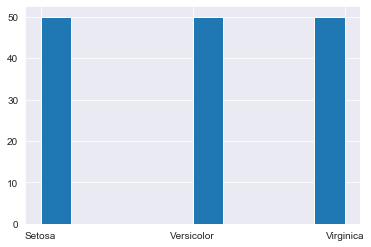

In [32]:
data["variety"].hist()

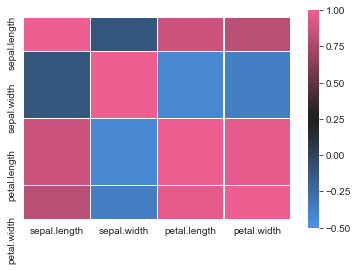

In [33]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [36]:
one_hot_encoded_data.head()

,sepal.length,sepal.width,petal.length,petal.width,variety_Setosa,variety_Versicolor,variety_Virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


In [42]:
from sklearn import preprocessing
  
# label_encoder object knows 
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
data['variety']= label_encoder.fit_transform(data['variety'])
  
data['variety'].unique()

array([0, 1, 2], dtype=int64)

In [49]:
data.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


AttributeError: module 'seaborn' has no attribute 'histplot'

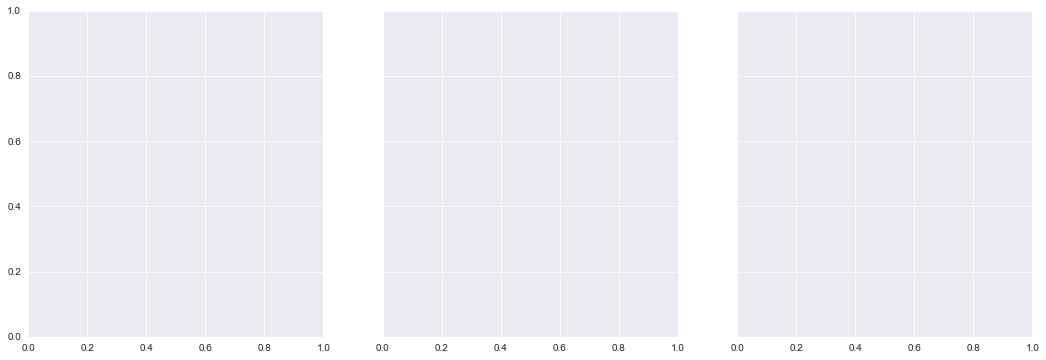

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="mean_radius", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="mean_smoothness", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="mean_texture", kde=True)


In [21]:
!python --version

Python 3.7.4


## Calculate P(Y=y) for all possible y

In [43]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

## Approach 1: Calculate P(X=x|Y=y) using Gaussian dist.

In [44]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [60]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)
    #print(prior)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

## Test Gaussian model

In [65]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="variety")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred))
#print(f1_score(Y_test, Y_pred))

[[ 9  0  0]
 [ 0 11  0]
 [ 0  2  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       0.85      1.00      0.92        11
           2       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.95      0.93      0.94        30
weighted avg       0.94      0.93      0.93        30

